In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
filess = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        
        f = (os.path.join(dirname, filename))
        filess.append(f)
        print(f)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-aug-2022/sample_submission.csv
/kaggle/input/tabular-playground-series-aug-2022/train.csv
/kaggle/input/tabular-playground-series-aug-2022/test.csv


# usefull packages

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier, BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier 
from sklearn import preprocessing, pipeline

from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings('ignore')


### plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# global variables 

In [3]:
RS = 143 # random state


In [4]:
test_data = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/test.csv')


main_data = pd.read_csv('/kaggle/input/tabular-playground-series-aug-2022/train.csv')
print(main_data.info())
print(main_data.head())


totl_len = (main_data.shape)
# print(totl_len)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26570 entries, 0 to 26569
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              26570 non-null  int64  
 1   product_code    26570 non-null  object 
 2   loading         26320 non-null  float64
 3   attribute_0     26570 non-null  object 
 4   attribute_1     26570 non-null  object 
 5   attribute_2     26570 non-null  int64  
 6   attribute_3     26570 non-null  int64  
 7   measurement_0   26570 non-null  int64  
 8   measurement_1   26570 non-null  int64  
 9   measurement_2   26570 non-null  int64  
 10  measurement_3   26189 non-null  float64
 11  measurement_4   26032 non-null  float64
 12  measurement_5   25894 non-null  float64
 13  measurement_6   25774 non-null  float64
 14  measurement_7   25633 non-null  float64
 15  measurement_8   25522 non-null  float64
 16  measurement_9   25343 non-null  float64
 17  measurement_10  25270 non-null 

**EDA: Exploratory Data Analysis**

In [5]:
main_data.describe()

,id,loading,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,measurement_3,measurement_4,measurement_5,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
count,26570.000000,26320.000000,26570.000000,26570.000000,26570.000000,26570.000000,26570.000000,26189.000000,26032.000000,25894.000000,...,25343.000000,25270.000000,25102.000000,24969.000000,24796.000000,24696.000000,24561.000000,24460.000000,24286.000000,26570.000000
mean,13284.500000,127.826233,6.754046,7.240459,7.415883,8.232518,6.256568,17.791528,11.731988,17.127804,...,11.430725,16.117711,19.172085,11.702464,15.652904,16.048444,14.995554,16.460727,701.269059,0.212608
std,7670.242662,39.030020,1.471852,1.456493,4.116690,4.199401,3.309109,1.001200,0.996085,0.996414,...,0.999137,1.405978,1.520785,1.488838,1.155247,1.491923,1.549226,1.708935,123.304161,0.409160
min,0.000000,33.160000,5.000000,5.000000,0.000000,0.000000,0.000000,13.968000,8.008000,12.073000,...,7.537000,9.323000,12.461000,5.167000,10.890000,9.140000,9.104000,9.701000,196.787000,0.000000
25%,6642.250000,99.987500,6.000000,6.000000,4.000000,5.000000,4.000000,17.117000,11.051000,16.443000,...,10.757000,15.209000,18.170000,10.703000,14.890000,15.057000,13.957000,15.268000,618.961500,0.000000
50%,13284.500000,122.390000,6.000000,8.000000,7.000000,8.000000,6.000000,17.787000,11.733000,17.132000,...,11.430000,16.127000,19.211500,11.717000,15.628500,16.040000,14.969000,16.436000,701.024500,0.000000
75%,19926.750000,149.152500,8.000000,8.000000,10.000000,11.000000,8.000000,18.469000,12.410000,17.805000,...,12.102000,17.025000,20.207000,12.709000,16.374000,17.082000,16.018000,17.628000,784.090250,0.000000
max,26569.000000,385.860000,9.000000,9.000000,29.000000,29.000000,24.000000,21.499000,16.484000,21.425000,...,15.412000,22.479000,25.640000,17.663000,22.713000,22.303000,21.626000,24.094000,1312.794000,1.000000


In [6]:
import statsmodels.api as sm

new_copy = main_data.copy()
new_copy = new_copy.dropna().reset_index(drop=True)
numerical_df = new_copy.iloc[:,10:-1].ffill().bfill()
numerical_out = new_copy[['failure']].ffill().bfill()

# spector_data = sm.datasets.spector.load_pandas()

numer_relat = sm.add_constant(numerical_df)
logit_mdl = sm.Probit(numerical_out, numer_relat ).fit()


Optimization terminated successfully.
         Current function value: 0.512464
         Iterations 5


In [7]:
# spector_data.endog
# spector_data.exog
# numerical_df

# main_data.failure.unique()
# # numer_relat
# logit_mdl.summary()

In [8]:
logit_mdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                          Probit Regression Results                           
==============================================================================
Dep. Variable:                failure   No. Observations:                12183
Model:                         Probit   Df Residuals:                    12167
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 Aug 2022   Pseudo R-squ.:                0.002391
Time:                        16:19:54   Log-Likelihood:                -6243.3
converged:                       True   LL-Null:                       -6258.3
Covariance Type:            nonrobust   LLR p-value:                   0.01218
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -1.1022      0.898     -1.227      0.220      -2.863       0.659
measurement_3      0.0041      0.013      0.316      0.752      -0.021       0.029
measurement_4     -0.0350      0.014     -2.574      0.010      -0.062      -0.008
measurement_5      0.0048      0.017      0.289      0.773      -0.028       0.038
measurement_6      0.0192      0.015      1.287      0.198      -0.010       0.048
measurement_7      0.0038      0.015      0.251      0.802      -0.026       0.034
measurement_8     -0.0184      0.017     -1.056      0.291      -0.053       0.016
measurement_9     -0.0009      0.013     -0.069      0.945      -0.027       0.025
measurement_10    -0.0007      0.009     -0.080      0.936      -0.019       0.017
measurement_11     0.0021      0.009      0.247      0.805      -0.015       0.019
measurement_12     0.0026      0.009      0.300      0.764      -0.015       0.020
measurement_13    -0.0025      0.011     -0.226      0.821      -0.024       0.019
measurement_14     0.0079      0.009      0.907      0.364      -0.009       0.025
measurement_15     0.0032      0.008      0.387      0.699      -0.013       0.020
measurement_16     0.0003      0.008      0.036      0.972      -0.015       0.015
measurement_17     0.0005      0.000      2.418      0.016    8.92e-05       0.001
==================================================================================
"""

In [9]:
### percentage of missing values of each column

nans = pd.DataFrame(main_data.isna().sum())
# nas = (nans/totl_len[0])*100

print(nans)


                   0
id                 0
product_code       0
loading          250
attribute_0        0
attribute_1        0
attribute_2        0
attribute_3        0
measurement_0      0
measurement_1      0
measurement_2      0
measurement_3    381
measurement_4    538
measurement_5    676
measurement_6    796
measurement_7    937
measurement_8   1048
measurement_9   1227
measurement_10  1300
measurement_11  1468
measurement_12  1601
measurement_13  1774
measurement_14  1874
measurement_15  2009
measurement_16  2110
measurement_17  2284
failure            0


In [10]:
dd = main_data.drop_duplicates()
dd.shape

(26570, 26)

In [11]:
chi1 = chi2_contingency(pd.crosstab(main_data.failure, main_data.product_code))
print('P value pf product_code :',chi1[1] )

chi2 = chi2_contingency(pd.crosstab(main_data.failure, main_data.attribute_0))   
print('P value pf attribute_0 :',chi2[1] )

chi3 = chi2_contingency(pd.crosstab(main_data.failure, main_data.attribute_1))   
print('P value pf attribute_1 :',chi3[1] )


chi4 = chi2_contingency(pd.crosstab(main_data.failure, main_data.attribute_2     ))   
print('P value pf attribute_2      :',chi4[1] )


chi5 = chi2_contingency(pd.crosstab(main_data.failure, main_data.attribute_3     ))   
print('P value pf attribute_3      :',chi5[1] )


chi2 = chi2_contingency(pd.crosstab(main_data.failure, main_data.measurement_0  ))   
print('P value pf measurement_0   :',chi2[1] )


chi2 = chi2_contingency(pd.crosstab(main_data.failure, main_data.measurement_1  ))   
print('P value pf measurement_1   :',chi2[1] )


chi2 = chi2_contingency(pd.crosstab(main_data.failure, main_data.measurement_2  ))   
print('P value pf measurement_2   :',chi2[1] )

P value pf product_code : 0.01127350444829385
P value pf attribute_0 : 0.01646496699489257
P value pf attribute_1 : 0.10533209307663303
P value pf attribute_2      : 0.010347678937392862
P value pf attribute_3      : 0.012130122905512169
P value pf measurement_0   : 0.3479901672244806
P value pf measurement_1   : 0.4447707909173552
P value pf measurement_2   : 0.06970430211442206


In [12]:
# ads = pd.crosstab(main_data.failure, main_data.product_code)
# ads


splits_df = main_data.copy()
splits_df['attribute_0'] = splits_df['attribute_0'].apply(lambda x:x.split('_')[1])

splits_df['attribute_1'] = splits_df['attribute_1'].apply(lambda x:x.split('_')[1])

chi1 = chi2_contingency(pd.crosstab(splits_df.failure, splits_df.product_code))
print('P value pf product_code :',chi1[1] )

chi2 = chi2_contingency(pd.crosstab(splits_df.failure, splits_df.attribute_0))   
print('P value pf attribute_0 :',chi2[1] )

chi3 = chi2_contingency(pd.crosstab(splits_df.failure, splits_df.attribute_1))   
print('P value pf attribute_1 :',chi3[1] )




chi4 = chi2_contingency(pd.crosstab(splits_df.failure, splits_df.attribute_2     ))   
print('P value pf attribute_2      :',chi4[1] )


chi5 = chi2_contingency(pd.crosstab(splits_df.failure, splits_df.attribute_3     ))   
print('P value pf attribute_3      :',chi5[1] )


chi2 = chi2_contingency(pd.crosstab(splits_df.failure, splits_df.measurement_0  ))   
print('P value pf measurement_0   :',chi2[1] )

P value pf product_code : 0.01127350444829385
P value pf attribute_0 : 0.01646496699489257
P value pf attribute_1 : 0.10533209307663303
P value pf attribute_2      : 0.010347678937392862
P value pf attribute_3      : 0.012130122905512169
P value pf measurement_0   : 0.3479901672244806


In [13]:
splits_df

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17,failure
0,0,A,80.10,7,8,9,5,7,8,4,...,10.672,15.859,17.594,15.193,15.029,NaN,13.034,14.684,764.100,0
1,1,A,84.89,7,8,9,5,14,3,3,...,12.448,17.947,17.915,11.755,14.732,15.425,14.395,15.631,682.057,0
2,2,A,82.43,7,8,9,5,12,1,5,...,12.715,15.607,NaN,13.798,16.711,18.631,14.094,17.946,663.376,0
3,3,A,101.07,7,8,9,5,13,2,6,...,12.471,16.346,18.377,10.020,15.250,15.562,16.154,17.172,826.282,0
4,4,A,188.06,7,8,9,5,9,2,8,...,10.337,17.082,19.932,12.428,16.182,12.760,13.153,16.412,579.885,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,E,158.95,7,6,6,9,6,16,4,...,NaN,12.177,17.942,10.112,15.795,18.572,16.144,NaN,729.131,0
26566,26566,E,146.02,7,6,6,9,10,12,8,...,11.242,14.179,20.564,10.234,14.450,14.322,13.146,16.471,853.924,0
26567,26567,E,115.62,7,6,6,9,1,10,1,...,11.407,16.437,17.476,8.668,15.069,16.599,15.590,14.065,750.364,0
26568,26568,E,106.38,7,6,6,9,2,9,4,...,11.392,17.064,17.814,14.928,16.273,15.485,13.624,12.865,730.156,0


# **Histogram plots **

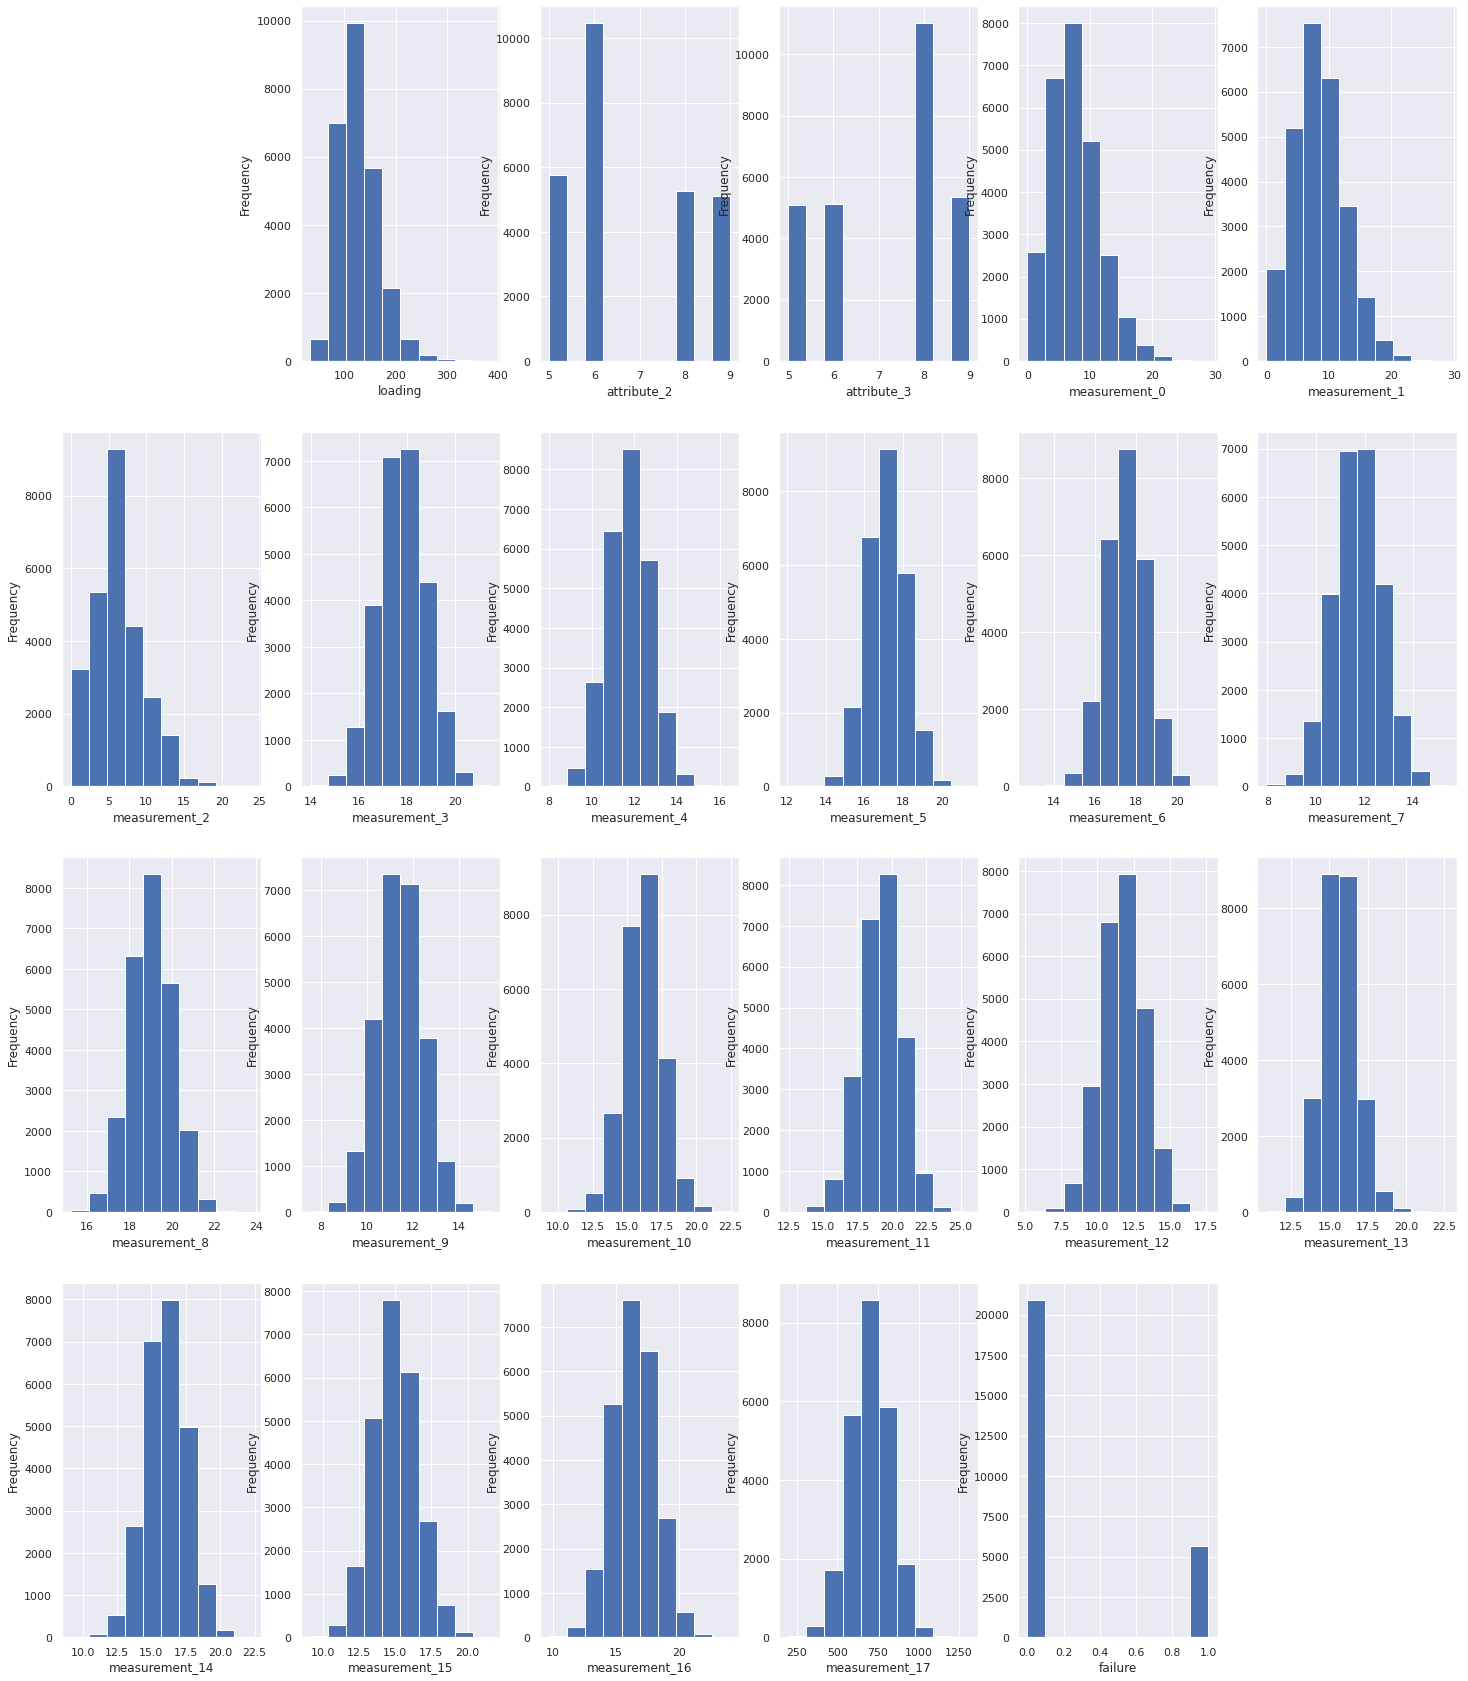

In [14]:
figr = plt.figure(figsize=(25,30))#,sharex=False,sharey=True)

numerics = main_data.select_dtypes(exclude=['object'])
inc = 0
for kol in numerics.columns:
    
    inc +=1
    if kol=='id':continue
    sub = figr.add_subplot(4,6,inc,)
    sub.set_xlabel(kol)
    numerics[kol].plot(kind='hist')


# Categorical Plots

In [15]:
# cat_cols = ['product_code', 'loading', 'attribute_0', 'attribute_1','attribute_2', 'attribute_3',]

# # figr = plt.subplots(nrows=4,ncols=6, sharey=True,)
# figr = plt.figure(figsize=(30,20))

# inc=0
# for kol in cat_cols:
#     print(kol)
#     inc+=1
#     subs = figr.add_subplot(4,4, inc)
#     subs.set_xlabel(kol)
#     chart = sns.countplot(data=main_data, x=str(kol), hue='failure',)


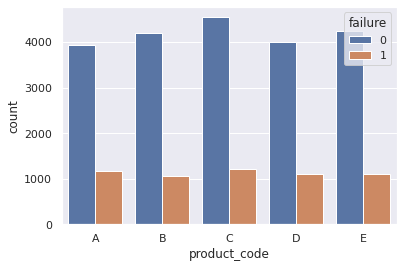

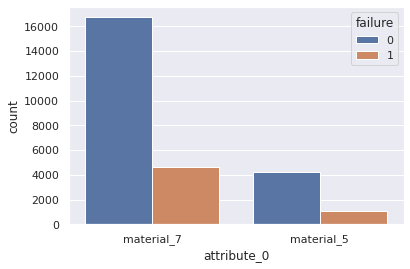

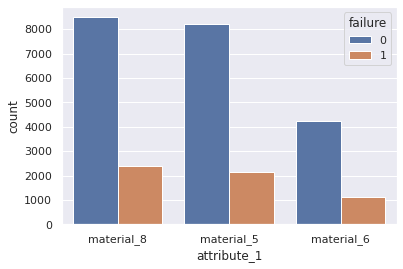

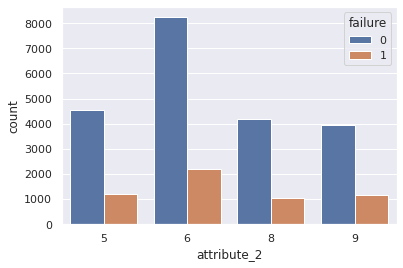

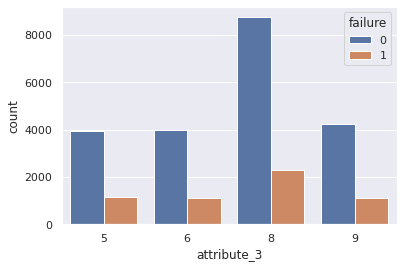

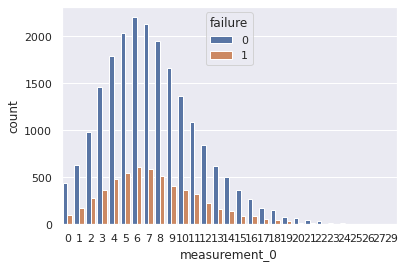

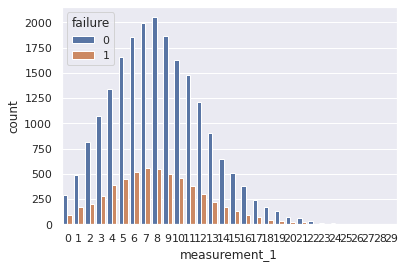

In [16]:
sns.countplot(data=main_data, x='product_code',  hue='failure')
plt.show()

sns.countplot(data=main_data, x='attribute_0',  hue='failure')
plt.show()

sns.countplot(data=main_data, x='attribute_1',  hue='failure')
plt.show()


sns.countplot(data=main_data, x='attribute_2',  hue='failure')
plt.show()


sns.countplot(data=main_data, x='attribute_3',  hue='failure')
plt.show()


sns.countplot(data=main_data, x='measurement_0',  hue='failure')
plt.show()


sns.countplot(data=main_data, x='measurement_1',  hue='failure')
plt.show()

# numerical/continous values vs Dependent variable

In [17]:
num_cols = ['attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17']



In [18]:
mm_df = main_data[num_cols]
min_max = preprocessing.MinMaxScaler(feature_range=(0,50))
names = mm_df.columns
min_max_df = min_max.fit_transform(mm_df,)

scaled_mmDF = pd.DataFrame(min_max_df, columns=names)
scaled_mmDF['failure']= main_data['failure']

In [19]:
main_data.columns


Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')

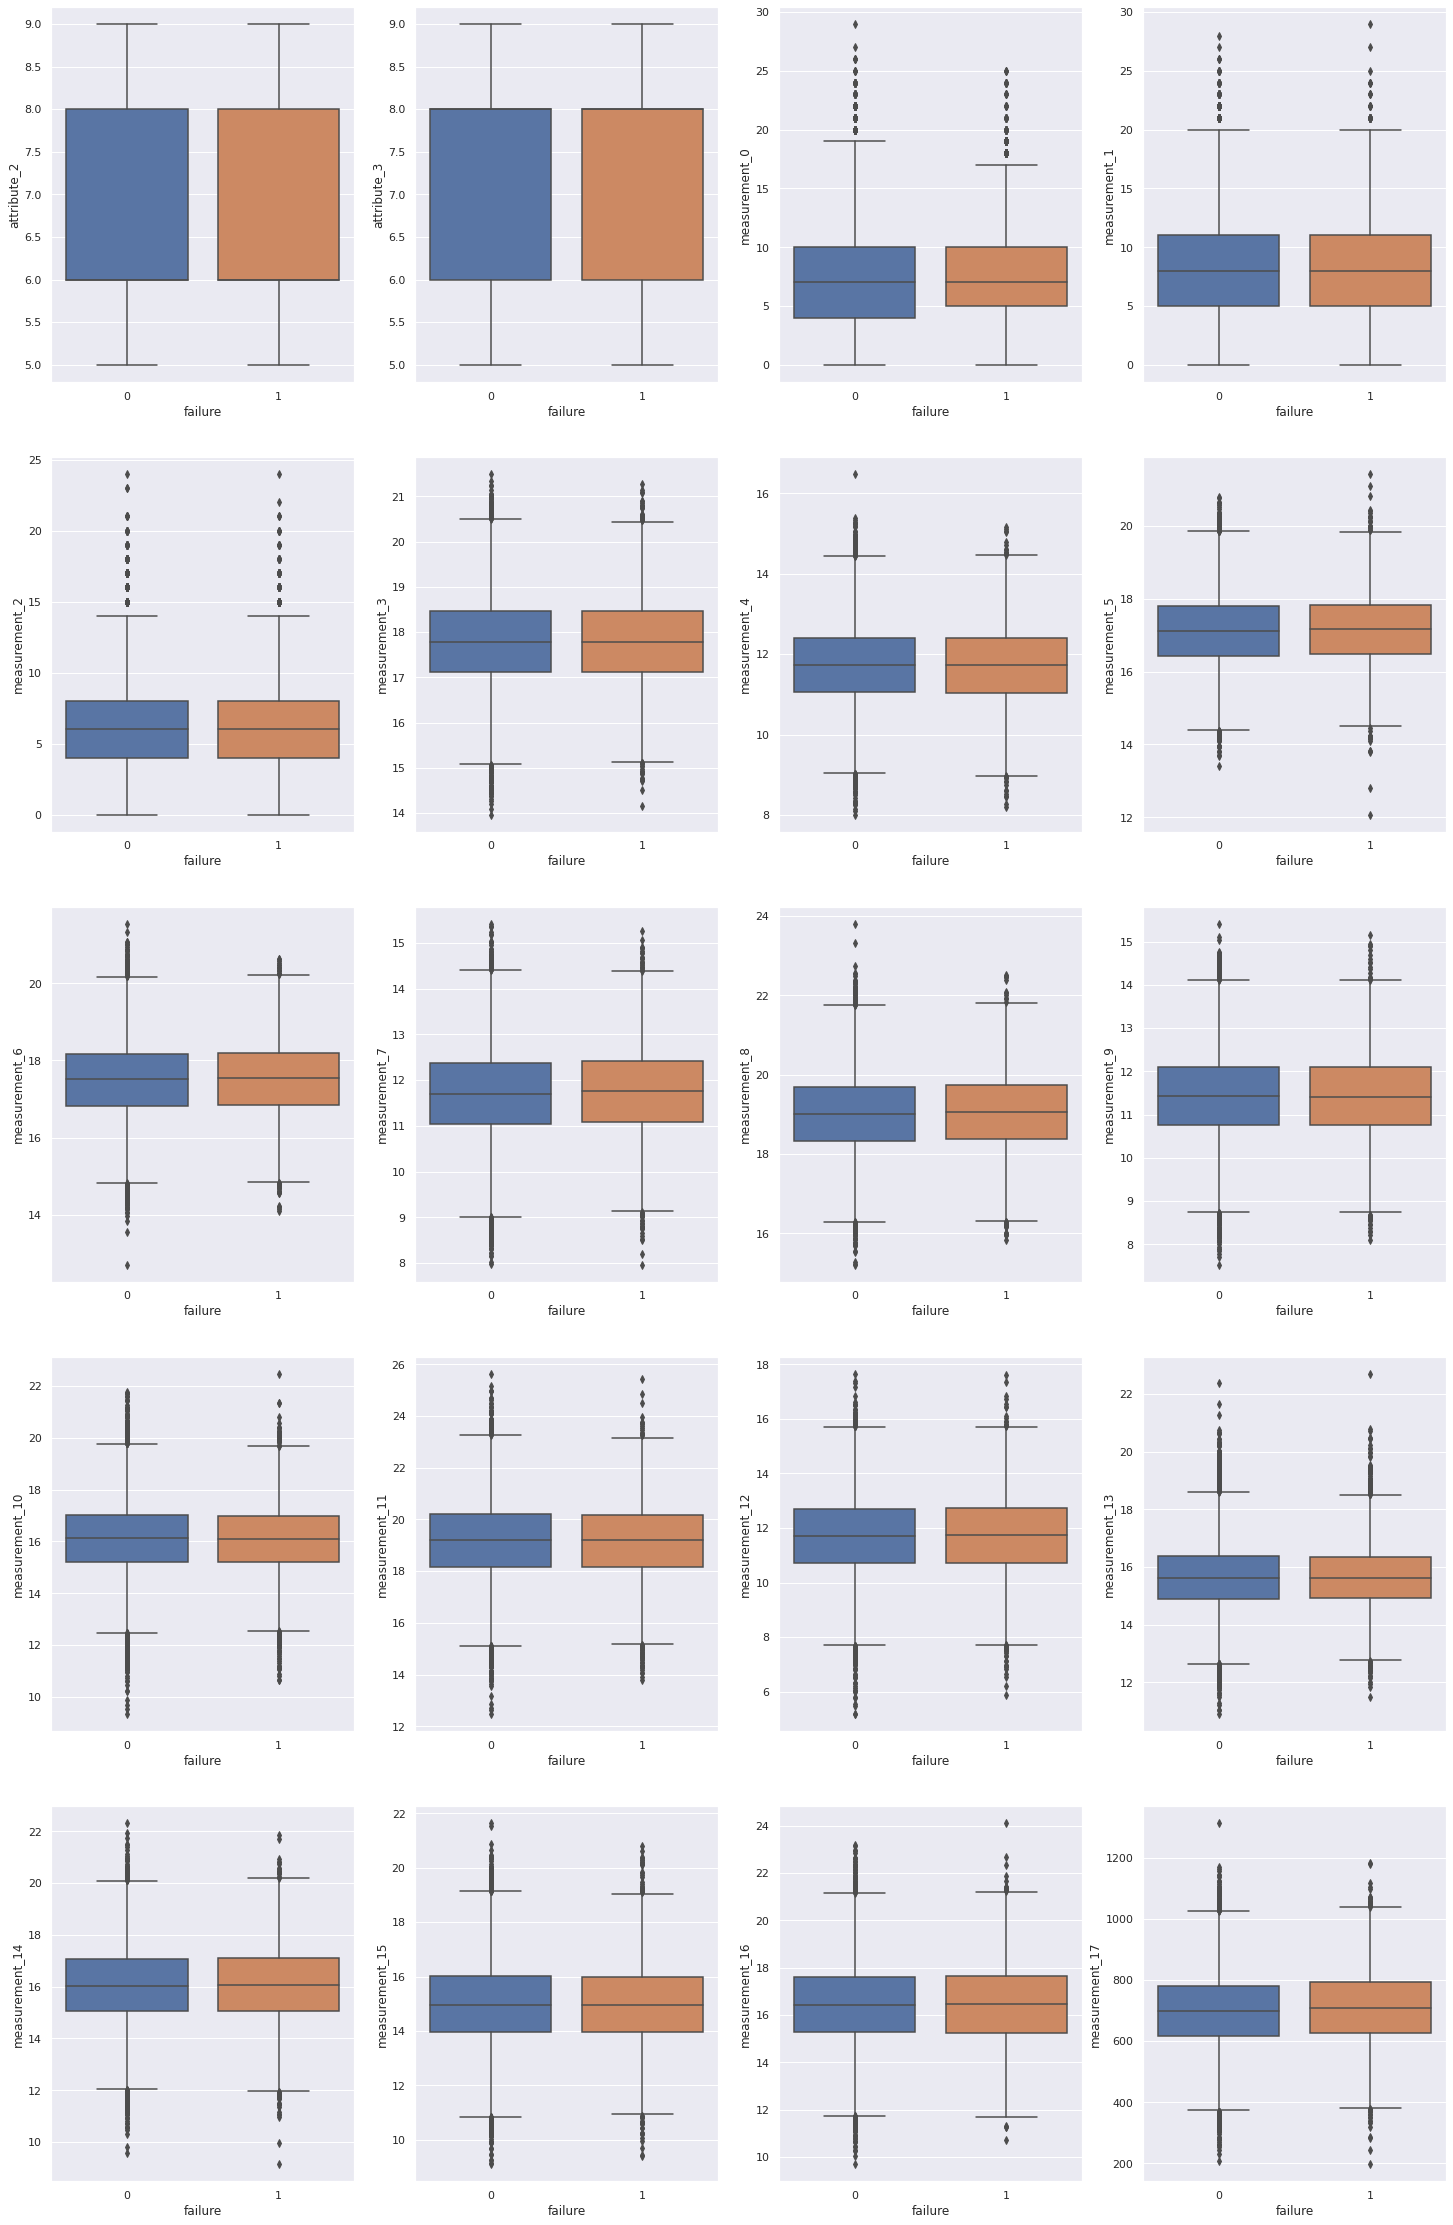

In [20]:

j = 0
jfig = plt.figure(figsize=(25,40))

for col in num_cols:
    j+=1
    subs = jfig.add_subplot(5,4,j)
    subs.set_xlabel(col)
    sns.boxplot(data=main_data, x='failure',y=col)
    

In [21]:
print(main_data.columns)

Index(['id', 'product_code', 'loading', 'attribute_0', 'attribute_1',
       'attribute_2', 'attribute_3', 'measurement_0', 'measurement_1',
       'measurement_2', 'measurement_3', 'measurement_4', 'measurement_5',
       'measurement_6', 'measurement_7', 'measurement_8', 'measurement_9',
       'measurement_10', 'measurement_11', 'measurement_12', 'measurement_13',
       'measurement_14', 'measurement_15', 'measurement_16', 'measurement_17',
       'failure'],
      dtype='object')


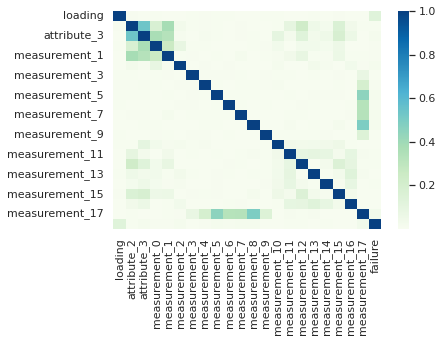

In [22]:

# print(main_data.corr())
sns.heatmap(abs(main_data.iloc[:,1:].corr()),cmap='GnBu')
plt.show()

In [23]:
print(main_data.dtypes)
for kol in main_data.columns:
    li = (main_data[kol].unique())
    li.sort()
    print(li)

id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object
[    0     1     2 ... 26567 26568 26569]
['A' 'B' 'C' 'D' 'E']
[ 33.16  39.45  40.81 ... 374.33 385.86    nan]
['material_5' 'material_7']
['material_5' 'material_6' 'material_8']
[5 6 8 9]
[5 6 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29]
[ 0  1  2  3  4  5 

In [24]:
main_data.dtypes

id                  int64
product_code       object
loading           float64
attribute_0        object
attribute_1        object
attribute_2         int64
attribute_3         int64
measurement_0       int64
measurement_1       int64
measurement_2       int64
measurement_3     float64
measurement_4     float64
measurement_5     float64
measurement_6     float64
measurement_7     float64
measurement_8     float64
measurement_9     float64
measurement_10    float64
measurement_11    float64
measurement_12    float64
measurement_13    float64
measurement_14    float64
measurement_15    float64
measurement_16    float64
measurement_17    float64
failure             int64
dtype: object

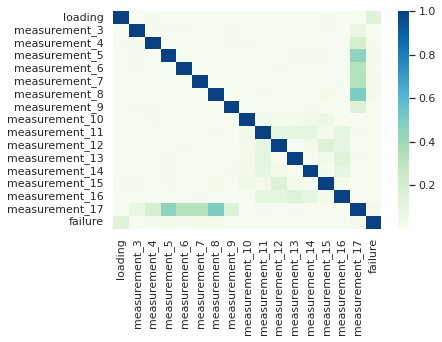

In [25]:
preproces_main = main_data.copy()
tmpr = preproces_main['failure']
preproces_main = preproces_main.select_dtypes(exclude=['object','int64']) #[preproces_main.dtypes == int]
preproces_main['failure'] = tmpr
preproces_main.head()


sns.heatmap(abs(preproces_main.corr()),cmap='GnBu')
plt.show()

In [26]:
sub_df = main_data.copy()
sub_df['attribute_0'] = (sub_df['attribute_0'].apply(lambda x:x.split('_')[1]))
sub_df['attribute_1'] = (sub_df['attribute_1'].apply(lambda x:x.split('_')[1]))

# label_encod = preprocessing.LabelEncoder()
# product_code_en= label_encod.fit(sub_df['product_code'])
# sub_df['product_code']  =product_code_en.transform(sub_df['product_code'])


# attribute_0_en = label_encod.fit(sub_df['attribute_0'])
# # sub_df['attribute_0'] = attribute_0_en.transform(sub_df['attribute_0'])


# attribute_1_en = label_encod.fit(sub_df['attribute_1'])
# sub_df['attribute_1'] = attribute_0_en.transform(sub_df['attribute_1'])


# sub_df['attribute_0'] = (sub_df['attribute_0'].apply(lambda x:x.split('_')[1]))

# for kol in sub_df.columns:
#     sub_df = sub_df[(sub_df[kol] != 'ffill')]

# print(sub_df.head())


# sub_df.drop(['id',"product_code", 'attribute_0', 'attribute_2', 'attribute_3',"attribute_1"], 
#             axis=1, inplace=True)

sub_df['measurement_17'] = sub_df['measurement_17'].fillna(sub_df['measurement_17'].mean())
sub_df['measurement_4'] = sub_df['measurement_4'].fillna(sub_df['measurement_4'].mean())
sub_df['measurement_8'] = sub_df['measurement_8'].fillna(sub_df['measurement_8'].mean())
sub_df['measurement_7'] = sub_df['measurement_7'].fillna(sub_df['measurement_7'].mean())
sub_df['measurement_9'] = sub_df['measurement_9'].fillna(sub_df['measurement_9'].mean())
sub_df['measurement_5'] = sub_df['measurement_5'].fillna(sub_df['measurement_5'].mean())
sub_df['measurement_6'] = sub_df['measurement_6'].fillna(sub_df['measurement_6'].mean())


sub_df['loading'] = sub_df['loading'].fillna(sub_df['loading'].mean())
sub_df['attribute_0'] = sub_df['attribute_0'].fillna(sub_df['attribute_0'].mode())
sub_df['attribute_2'] = sub_df['attribute_2'].fillna(sub_df['attribute_2'].mode())
sub_df['attribute_3'] = sub_df['attribute_3'].fillna(sub_df['attribute_3'].mode())

sub_df['measurement_5x8'] = sub_df['measurement_5'] *sub_df['measurement_8'] 
sub_df['measurement_6x7'] = sub_df['measurement_6'] *sub_df['measurement_7'] 
sub_df['measurement_4x9'] = sub_df['measurement_4'] *sub_df['measurement_9'] 



new_extraCols = [ 'measurement_16','measurement_15','measurement_12','measurement_11','measurement_14','measurement_10',
                 'measurement_13','measurement_7','measurement_3','measurement_5','measurement_6','measurement_8']

colums = ['attribute_0','attribute_1','attribute_2','attribute_3','loading','measurement_4','measurement_17', 'measurement_5x8', 'measurement_6x7', 'measurement_4x9','failure']

# colums = ['loading','failure']
# colums = sorted(list(set(colums+new_extraCols)))
sub_df = sub_df[colums]

for kol in colums:
    sub_df[kol] = sub_df[kol].fillna(sub_df[kol].mean()).astype(float)

sub_df = sub_df.dropna().reset_index(drop=True)
# sub_df = sub_df.ffill().bfill().reset_index(drop=True)
inputs = sub_df.iloc[:,:-1].values
outputs = sub_df.iloc[:,-1].values


train_inputs, test_inputs, train_outputs,test_outputs = train_test_split(inputs,outputs,
                                                                         test_size=0.3,random_state=RS)


In [27]:
# len(train_inputs)
# train_outputs
# # list(range(2,25))
# # print(sub_df.head())
# print(sub_df)
colums
train_inputs
sub_df

,attribute_0,attribute_1,attribute_2,attribute_3,loading,measurement_4,measurement_17,measurement_5x8,measurement_6x7,measurement_4x9,failure
0,7.0,8.0,9.0,5.0,80.10,12.518000,764.100,317.400940,226.468788,133.592096,0.0
1,7.0,8.0,9.0,5.0,84.89,11.540000,682.057,316.939413,228.099964,143.649920,0.0
2,7.0,8.0,9.0,5.0,82.43,11.652000,663.376,306.104544,231.976320,148.155180,0.0
3,7.0,8.0,9.0,5.0,101.07,11.188000,826.282,354.058560,230.759637,139.525548,0.0
4,7.0,8.0,9.0,5.0,188.06,12.950000,579.885,307.400070,178.024276,133.864150,0.0
...,...,...,...,...,...,...,...,...,...,...,...
26565,7.0,6.0,6.0,9.0,158.95,13.259000,729.131,349.688072,168.461825,151.559977,0.0
26566,7.0,6.0,6.0,9.0,146.02,11.731988,853.924,351.820992,212.509842,131.891008,0.0
26567,7.0,6.0,6.0,9.0,115.62,11.535000,750.364,323.463062,213.817550,131.579745,0.0
26568,7.0,6.0,6.0,9.0,106.38,11.731988,730.156,327.498644,212.017013,133.650806,0.0


# modeling

In [28]:
### decision tree

dt_classi = DecisionTreeClassifier(max_depth=5, random_state=RS)
        
dt_params = {
            'max_depth':list(range(2,15)),
            'criterion':["gini", "entropy"],
            'splitter':['best','random'],
            'max_features':['auto','sqrt','log2']
            }
dt_model = GridSearchCV(dt_classi,
                        dt_params, cv=2,scoring= 'roc_auc',n_jobs=-1, verbose=1)# 'roc_auc', neg_log_loss

dt_model.fit(train_inputs,train_outputs)

### train data , accuracy checks and developments
train_outputs_pred = dt_model.predict(train_inputs)
print(f'*************************\ntrain outputs data of size :{len(train_outputs_pred)}\n*************************')
print(f'accuracy metric: {accuracy_score(train_outputs, train_outputs_pred)} \n')
print(f'classification report: \n{classification_report(train_outputs, train_outputs_pred)} \n')
print(f'confusion matrix: \n{confusion_matrix(train_outputs, train_outputs_pred)}\n')
print(f'mean absoute error: \n{mean_absolute_error(train_outputs, train_outputs_pred)}\n')
print(f'roc_auc_score error: \n{roc_auc_score(train_outputs, train_outputs_pred)}\n')



### trains test data, accuracy checks
test_outputs_pred = dt_model.predict(test_inputs)

print(f'*************************\ntrains tests outputs data of size :{len(test_outputs_pred)}\n*************************')
print(f'accuracy metric: {accuracy_score(test_outputs, test_outputs_pred)} \n')
print(f'classification report: \n{classification_report(test_outputs, test_outputs_pred)} \n')
print(f'confusion matrix: \n{confusion_matrix(test_outputs, test_outputs_pred)}')
print(f'mean absoute error: \n{mean_absolute_error(test_outputs, test_outputs_pred)}\n')
print(f'roc_auc_score error: \n{roc_auc_score(test_outputs, test_outputs_pred)}\n')


# import sklearn as skl
# sorted(skl.metrics.SCORERS.keys())
print(dt_model.best_params_)

print(dt_model.score(test_inputs,test_outputs))
# train_inputs
# train_outputs

print(dt_model.classes_)


### predict probabilities of failures/outputs

proba_test_outs = dt_model.predict_proba(test_inputs)

log_proba_test_outs = dt_model.predict_log_proba(test_inputs)

probs_tmpr = np.round(log_proba_test_outs,1)
df_temp = pd.DataFrame(probs_tmpr)
# print('log_proba_test_outs \n',df_temp)

probs_tmpr = np.round(proba_test_outs,1)
df_temp = pd.DataFrame(probs_tmpr)
# print(df_temp)



print(f'mean_squared_error dt_model: \n{mean_squared_error(test_outputs, df_temp[1])}\n')
# print(f'accuracy metric: {accuracy_score(test_outputs, df_temp[1])} \n')
print(f'mean absoute error: \n{mean_absolute_error(test_outputs, df_temp[1])}\n')
print(f'roc_auc_score error: \n{roc_auc_score(test_outputs, df_temp[1])}\n')

Fitting 2 folds for each of 156 candidates, totalling 312 fits
*************************
train outputs data of size :18599
*************************
accuracy metric: 0.7914941663530297 

classification report: 
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     14707
         1.0       1.00      0.00      0.01      3892

    accuracy                           0.79     18599
   macro avg       0.90      0.50      0.45     18599
weighted avg       0.84      0.79      0.70     18599
 

confusion matrix: 
[[14707     0]
 [ 3878    14]]

mean absoute error: 
0.20850583364697026

roc_auc_score error: 
0.5017985611510791

*************************
trains tests outputs data of size :7971
*************************
accuracy metric: 0.779575962865387 

classification report: 
              precision    recall  f1-score   support

         0.0       0.78      1.00      0.88      6214
         1.0       0.50      0.00      0.00      1757

    accu

XGBoost

In [29]:
# ### x g b
# from xgboost import XGBClassifier

# xgbc = XGBClassifier(  random_state=RS,)
        
# xgbs_params = {
#             'max_depth':list(range(2,15)),
#             'n_estimators':[100,200,500,1000],
#             'learning_rate':[0.05, 0.1,0.15],
#             }
# xgbc_models = GridSearchCV(xgbc,
#                             xgbs_params, cv=2,scoring= 'roc_auc',n_jobs=-1, verbose=1)# 'roc_auc', neg_log_loss

# xgbc_model = xgbc_models.fit(train_inputs,train_outputs)

# ### train data , accuracy checks and developments
# train_outputs_pred = xgbc_model.predict(train_inputs)
# print(f'*************************\ntrain outputs data of size :{len(train_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(train_outputs, train_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(train_outputs, train_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(train_outputs, train_outputs_pred)}\n')
# print(f'mean absoute error: \n{mean_absolute_error(train_outputs, train_outputs_pred)}\n')
# print(f'roc_auc_score error: \n{roc_auc_score(train_outputs, train_outputs_pred)}\n')



# ### trains test data, accuracy checks
# test_outputs_pred = xgbc_model.predict(test_inputs)

# print(f'*************************\ntrains tests outputs data of size :{len(test_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(test_outputs, test_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(test_outputs, test_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(test_outputs, test_outputs_pred)}')
# print(f'mean absoute error: \n{mean_absolute_error(test_outputs, test_outputs_pred)}\n')
# print(f'roc_auc_score error: \n{roc_auc_score(test_outputs, test_outputs_pred)}\n')

# '--------------------------------------------------------------------------------------'
# ### predict probabilities of failures/outputs

# proba_test_outs = xgbc_model.predict_proba(test_inputs)

# probs_tmpr = np.round(proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)

# # print(df_temp)



# print(f'mean_squared_error dt_model: \n{mean_squared_error(test_outputs, df_temp[1])}\n')
# # print(f'accuracy metric: {accuracy_score(test_outputs, df_temp[1])} \n')
# print(f'mean absoute error: \n{mean_absolute_error(test_outputs, df_temp[1])}\n')
# print(f'roc_auc_score error: \n{roc_auc_score(test_outputs, df_temp[1])}\n')


# # scores = cross_val_score(xgbc, xtrain, ytrain, cv=5)

Random Forest

In [30]:
# ### random forest classifier model

# rf_mdl = RandomForestClassifier(random_state=RS, n_jobs=-1)
# rf_params = {'n_estimators':[50,100,],
#             'max_depth':list(range(2,10)),
#             'criterion':["gini", "entropy"],
#             'max_features':['auto','sqrt','log2']}

# rf_class = GridSearchCV(rf_mdl, rf_params, cv=2,n_jobs=-1,scoring='roc_auc',verbose=True)
# rf_class.fit(train_inputs,train_outputs)


# ### train data , accuracy checks and developments
# train_outputs_pred = rf_class.predict(train_inputs)
# print(f'*************************\ntrain outputs data of size :{len(train_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(train_outputs, train_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(train_outputs, train_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(train_outputs, train_outputs_pred)}\n')
# print(f'mean absoute error: \n{mean_absolute_error(train_outputs, train_outputs_pred)}\n')



# ### trains test data, accuracy checks
# test_outputs_pred = rf_class.predict(test_inputs)

# print(f'*************************\ntrains tests outputs data of size :{len(test_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(test_outputs, test_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(test_outputs, test_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(test_outputs, test_outputs_pred)}')
# print(f'mean absoute error: \n{mean_absolute_error(test_outputs, test_outputs_pred)}\n')
# print(f'roc_auc_score error: \n{roc_auc_score(test_outputs, test_outputs_pred)}\n')

# # print('cols: \n',test_inputs.columns)

In [31]:
# ### predict probabilities of failures/outputs

# proba_test_outs = rf_class.predict_proba(test_inputs)

# log_proba_test_outs = rf_class.predict_log_proba(test_inputs)


# ## log probabilities is not required here in this case
# probs_tmpr = np.round(log_proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# # print('log_proba_test_outs rf_class \n',df_temp)


# ## just probabilities for a class is the one expected here
# probs_tmpr = np.round(proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# print(df_temp)



# # print(f'accuracy metric: {accuracy_score(test_outputs, df_temp[1])} \n')
# print(f'mean absoute error rf_class: \n{mean_absolute_error(test_outputs, df_temp[1])}\n')

# print(f'mean_squared_error rf_class: \n{mean_squared_error(test_outputs, df_temp[1])}\n')


# print(f'roc_auc_score rf_class: \n{roc_auc_score(test_outputs, df_temp[1])}\n')

Naive bayes

In [32]:
# from sklearn.naive_bayes import GaussianNB,CategoricalNB



# ### Naive_Bayes classifier model
# Naive_Bayes = CategoricalNB() # Naive_Bayes_mdl

# Naive_Bayes_params = {'n_estimators':[50,100,],
#             'max_depth':list(range(2,10)),
#             'criterion':["gini", "entropy"],
#             'max_features':['auto','sqrt','log2']}

# # Naive_Bayes = GridSearchCV(Naive_Bayes_mdl, Naive_Bayes_params, cv=2,n_jobs=-1,scoring='roc_auc',verbose=True)
# Naive_Bayes.fit(train_inputs,train_outputs)

# ### train data , accuracy checks and developments
# train_outputs_pred = Naive_Bayes.predict(train_inputs)
# print(f'*************************\ntrain outputs data of size :{len(train_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(train_outputs, train_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(train_outputs, train_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(train_outputs, train_outputs_pred)}\n')
# print(f'mean absoute error: \n{mean_absolute_error(train_outputs, train_outputs_pred)}\n')



# ### trains test data, accuracy checks
# # test_outputs_pred = Naive_Bayes.predict(test_inputs)

# # print(f'*************************\ntrains tests outputs data of size :{len(test_outputs_pred)}\n*************************')
# # print(f'accuracy metric: {accuracy_score(test_outputs, test_outputs_pred)} \n')
# # print(f'classification report: \n{classification_report(test_outputs, test_outputs_pred)} \n')
# # print(f'confusion matrix: \n{confusion_matrix(test_outputs, test_outputs_pred)}')
# # print(f'mean absoute error: \n{mean_absolute_error(test_outputs, test_outputs_pred)}\n')



In [33]:
# Naive_Bayes.get_params()
# # test_inputs.shape

# ### predict probabilities of failures/outputs

# proba_test_outs = Naive_Bayes.predict_proba(test_inputs)

# log_proba_test_outs = Naive_Bayes.predict_log_proba(test_inputs)


# ## log probabilities is not required here in this case
# probs_tmpr = np.round(log_proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# # print('log_proba_test_outs rf_class \n',df_temp)


# ## just probabilities for a class is the one expected here
# probs_tmpr = np.round(proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# print(df_temp)



# # print(f'accuracy metric: {accuracy_score(test_outputs, df_temp[1])} \n')
# print(f'mean absoute error Naive_Bayes: \n{mean_absolute_error(test_outputs, df_temp[1])}\n')

# print(f'mean_squared_error Naive_Bayes: \n{mean_squared_error(test_outputs, df_temp[1])}\n')
# print(f'roc_auc_score Naive_Bayes: \n{roc_auc_score(test_outputs, df_temp[1])}\n')


linear svc

In [34]:
# ### svc classifier model

# from sklearn import svm

# # linearsvm_mdl = svm.LinearSVC(random_state=RS, max_iter=-1)
# # svm_params = { 
# #             'penalty':['l1', 'l2'],
# #             'loss':['squared_hinge', 'hinge']}

# # linearsvm_class = GridSearchCV(linearsvm_mdl, svm_params, cv=5,n_jobs=-1,scoring='roc_auc',verbose=True)
# # linearsvm_class.fit(train_inputs,train_outputs)


# from sklearn.ensemble import AdaBoostClassifier
# adaBoost = AdaBoostClassifier(random_state=RS)
# adaB_params = { 
#             'n_estimators':[50,100],
#             'learning_rate':[0.1,0.2,0.5,1,1.5]}
# adaBoost_class = GridSearchCV(adaBoost, adaB_params, cv=5,n_jobs=-1,scoring='roc_auc',verbose=True)
# adaBoost_class.fit(train_inputs,train_outputs)



# ### train data , accuracy checks and developments
# train_outputs_pred = adaBoost_class.predict(train_inputs)
# print(f'*************************\ntrain outputs data of size :{len(train_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(train_outputs, train_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(train_outputs, train_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(train_outputs, train_outputs_pred)}\n')
# print(f'mean absoute error: \n{mean_absolute_error(train_outputs, train_outputs_pred)}\n')



# ### trains test data, accuracy checks
# test_outputs_pred = adaBoost_class.predict(test_inputs)

# print(f'*************************\ntrains tests outputs data of size :{len(test_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(test_outputs, test_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(test_outputs, test_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(test_outputs, test_outputs_pred)}')
# print(f'mean absoute error: \n{mean_absolute_error(test_outputs, test_outputs_pred)}\n')

# print('adaBoost_class: \n',adaBoost_class.get_params)

In [35]:
# adaBoost_class.best_params_
# ### predict probabilities of failures/outputs

# proba_test_outs = adaBoost_class.predict_proba(test_inputs)

# log_proba_test_outs = adaBoost_class.predict_log_proba(test_inputs)


# ## log probabilities is not required here in this case
# probs_tmpr = np.round(log_proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# # print('log_proba_test_outs rf_class \n',df_temp)


# ## just probabilities for a class is the one expected here
# probs_tmpr = np.round(proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# # print(df_temp)



# # print(f'accuracy metric: {accuracy_score(test_outputs, df_temp[1])} \n')
# print(f'mean absoute error rf_class: \n{mean_absolute_error(test_outputs, df_temp[1])}\n')

# print(f'mean_squared_error rf_class: \n{mean_squared_error(test_outputs, df_temp[1])}\n')

SVM

In [36]:
# ### svc classifier model

# from sklearn import svm

# svm_mdl = svm.SVC(random_state=RS, max_iter=-1)
# svm_params = { 
#             'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
#             'gamma':['scale', 'auto']}

# svm_class = GridSearchCV(svm_mdl, svm_params, cv=5,n_jobs=-1,scoring='roc_auc',verbose=True)
# svm_class.fit(train_inputs,train_outputs)




# ### train data , accuracy checks and developments
# train_outputs_pred = svm_class.predict(train_inputs)
# print(f'*************************\ntrain outputs data of size :{len(train_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(train_outputs, train_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(train_outputs, train_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(train_outputs, train_outputs_pred)}\n')
# print(f'mean absoute error: \n{mean_absolute_error(train_outputs, train_outputs_pred)}\n')



# ### trains test data, accuracy checks
# test_outputs_pred = svm_class.predict(test_inputs)

# print(f'*************************\ntrains tests outputs data of size :{len(test_outputs_pred)}\n*************************')
# print(f'accuracy metric: {accuracy_score(test_outputs, test_outputs_pred)} \n')
# print(f'classification report: \n{classification_report(test_outputs, test_outputs_pred)} \n')
# print(f'confusion matrix: \n{confusion_matrix(test_outputs, test_outputs_pred)}')
# print(f'mean absoute error: \n{mean_absolute_error(test_outputs, test_outputs_pred)}\n')

# # print('cols: \n',test_inputs.columns)

In [37]:
# ### predict probabilities of failures/outputs

# proba_test_outs = svm_class.predict_proba(test_inputs)

# # log_proba_test_outs = svm_class.predict_log_proba(test_inputs)


# ## log probabilities is not required here in this case
# probs_tmpr = np.round(log_proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# # print('log_proba_test_outs rf_class \n',df_temp)


# ## just probabilities for a class is the one expected here
# probs_tmpr = np.round(proba_test_outs,1)
# df_temp = pd.DataFrame(probs_tmpr)
# print(df_temp)



# # print(f'accuracy metric: {accuracy_score(test_outputs, df_temp[1])} \n')
# print(f'mean absoute error rf_class: \n{mean_absolute_error(test_outputs, df_temp[1])}\n')

# print(f'mean_squared_error rf_class: \n{mean_squared_error(test_outputs, df_temp[1])}\n')

further data analysis

In [38]:
for kol in main_data.columns:
    li = (main_data[kol].unique())
    li.sort()
    print(li)

[    0     1     2 ... 26567 26568 26569]
['A' 'B' 'C' 'D' 'E']
[ 33.16  39.45  40.81 ... 374.33 385.86    nan]
['material_5' 'material_7']
['material_5' 'material_6' 'material_8']
[5 6 8 9]
[5 6 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
[13.968 14.1   14.166 ... 21.336 21.499    nan]
[ 8.008  8.097  8.155 ... 15.379 16.484    nan]
[12.073 12.813 13.395 ... 21.097 21.425    nan]
[12.715 13.566 13.839 ... 21.329 21.543    nan]
[ 7.968  7.973  8.027 ... 15.359 15.419    nan]
[15.217 15.22  15.268 ... 23.328 23.807    nan]
[ 7.537  7.701  7.78  ... 15.154 15.412    nan]
[ 9.323  9.54   9.676 ... 21.761 22.479    nan]
[12.461 12.62  12.703 ... 25.429 25.64     nan]
[ 5.167  5.181  5.489 ... 17.594 17.663    nan]
[10.89  11.035 11.052 ... 22.388 22.713    nan]
[ 9.14   9

In [39]:
for kol in test_data.columns:
    li = (test_data[kol].unique())
    li.sort()
    print(li)

[26570 26571 26572 ... 47342 47343 47344]
['F' 'G' 'H' 'I']
[ 37.7   42.77  42.86 ... 362.7  385.57    nan]
['material_5' 'material_7']
['material_5' 'material_6' 'material_7']
[6 7 9]
[4 5 7 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 31 32 33]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 28]
[13.565 13.637 14.132 ... 21.306 21.389    nan]
[ 7.384  8.009  8.037 ... 15.268 15.623    nan]
[12.215 13.439 13.474 ... 21.11  21.681    nan]
[13.539 13.551 13.626 ... 21.131 21.183    nan]
[ 7.853  8.041  8.085 ... 15.47  15.828    nan]
[14.885 14.971 15.206 ... 22.828 23.092    nan]
[ 7.578  7.669  7.7   ... 15.086 15.091    nan]
[ 9.167  9.386  9.403 ... 22.259 23.354    nan]
[13.127 13.146 13.151 ... 24.648 24.95     nan]
[ 6.116  6.154  6.273 ... 17.686 18.962    nan]
[ 9.209  9.892  9.903 ... 21.071 21.677    

In [40]:
('I' in test_data.values)

True

# test data EDA

In [41]:
f_tdf  = test_data.copy()
f_tdf.head()

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_8,measurement_9,measurement_10,measurement_11,measurement_12,measurement_13,measurement_14,measurement_15,measurement_16,measurement_17
0,26570,F,119.57,material_5,material_6,6,4,6,9,6,...,18.654,10.802,15.909,18.070,13.772,13.659,16.825,13.742,17.710,634.612
1,26571,F,113.51,material_5,material_6,6,4,11,8,0,...,19.368,12.032,13.998,NaN,12.473,17.468,16.708,14.776,14.102,537.037
2,26572,F,112.16,material_5,material_6,6,4,8,12,4,...,17.774,11.743,17.046,18.086,10.907,13.363,15.737,17.065,16.021,658.995
3,26573,F,112.72,material_5,material_6,6,4,8,11,10,...,18.948,11.790,18.165,16.163,10.933,15.501,15.667,12.620,16.111,594.301
4,26574,F,208.00,material_5,material_6,6,4,14,16,8,...,19.141,12.370,14.578,17.849,11.941,16.070,16.183,13.324,17.150,801.044


In [42]:
print(f_tdf.isna().sum())

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64


In [43]:
print(f_tdf['product_code'].value_counts())
print(f_tdf['attribute_0'].value_counts())
print(f_tdf['attribute_1'].value_counts())



F    5422
I    5228
G    5107
H    5018
Name: product_code, dtype: int64
material_5    10529
material_7    10246
Name: attribute_0, dtype: int64
material_6    10529
material_5     5228
material_7     5018
Name: attribute_1, dtype: int64


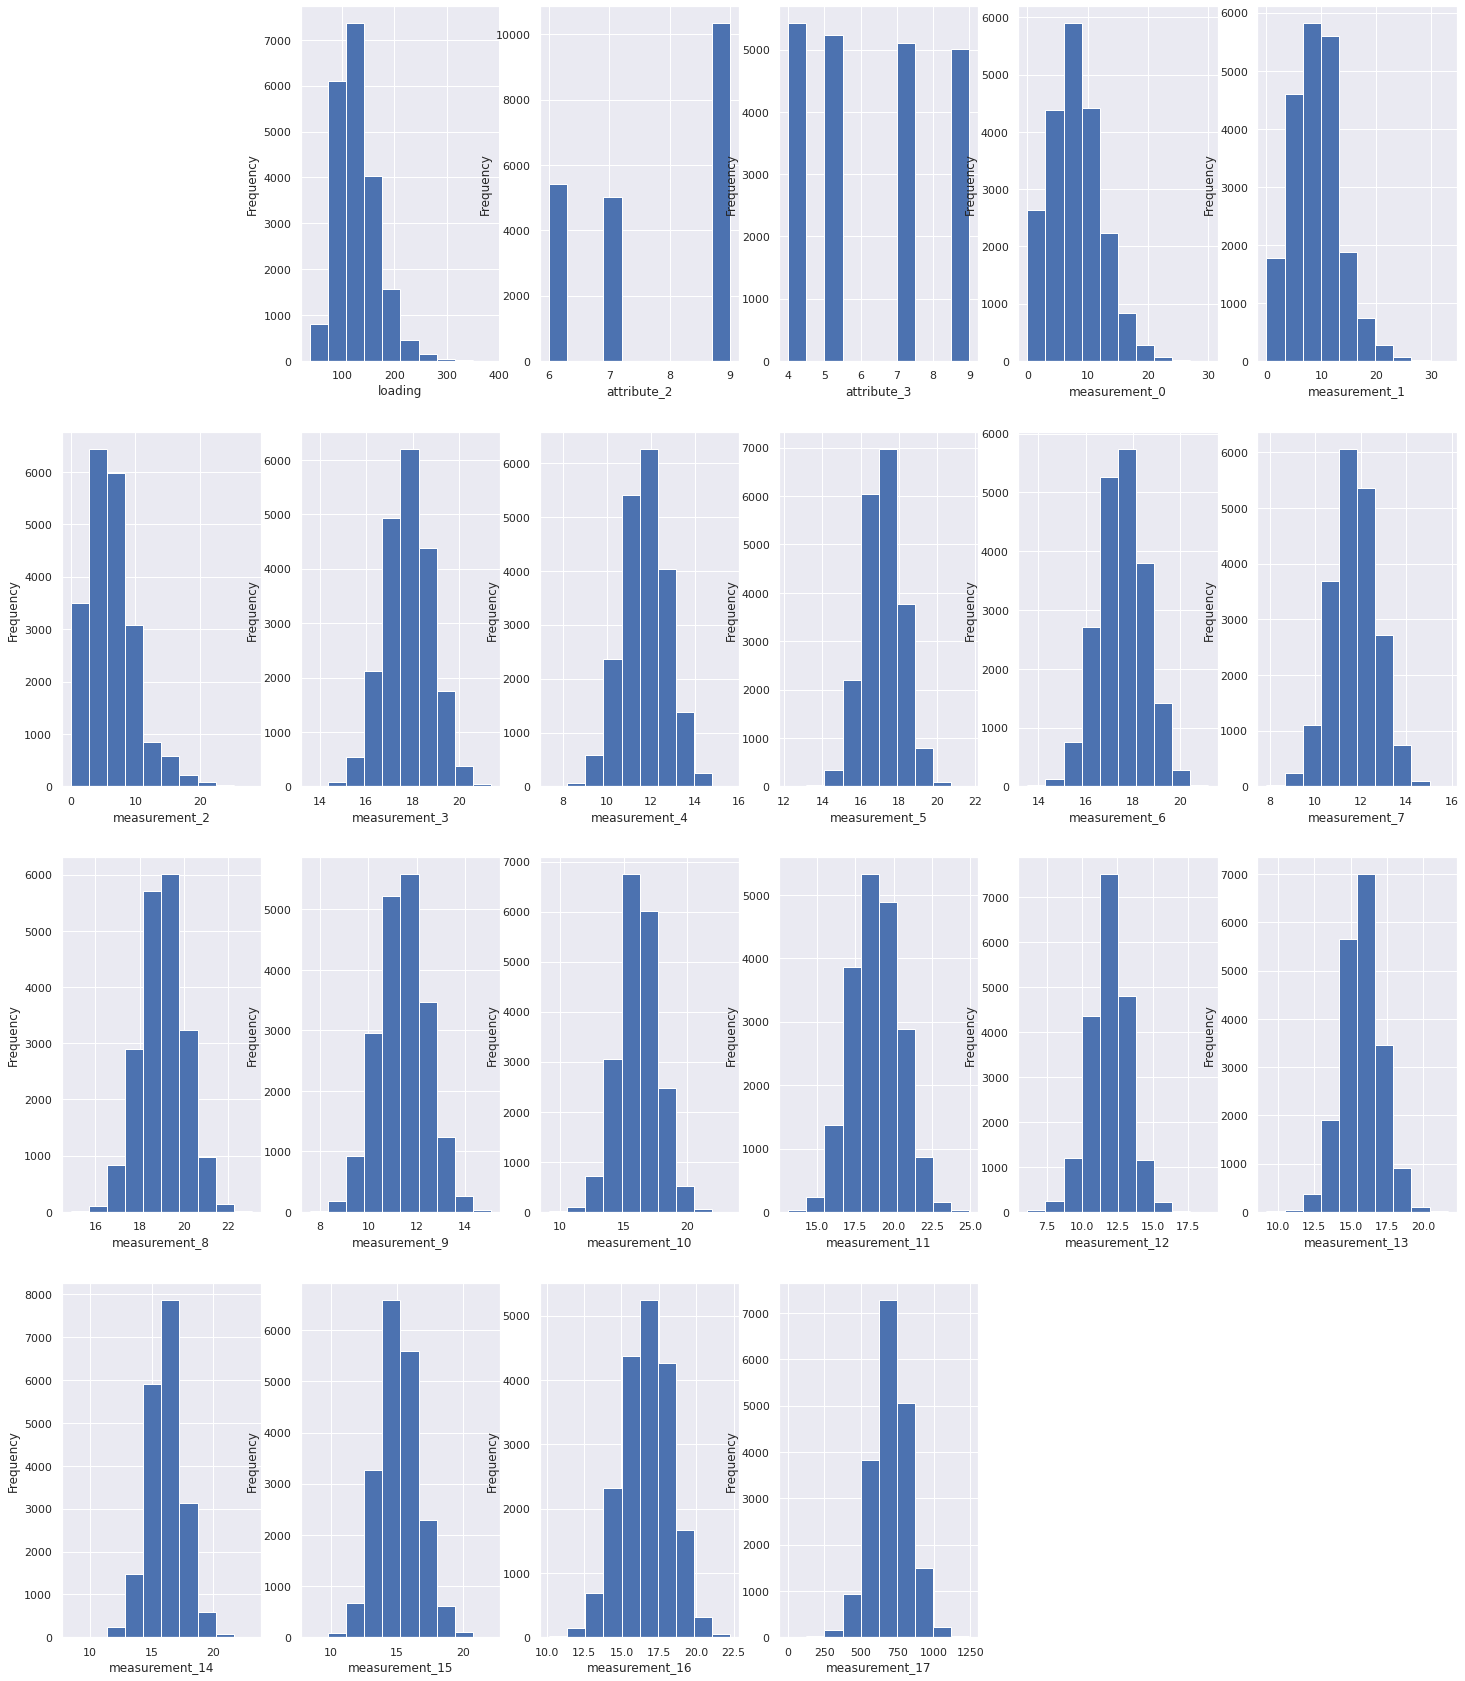

In [44]:
figr = plt.figure(figsize=(25,30))#,sharex=False,sharey=True)

numerics = f_tdf.select_dtypes(exclude=['object'])
inc = 0
for kol in numerics.columns:
    
    inc +=1
    if kol=='id':continue
    sub = figr.add_subplot(4,6,inc,)
    sub.set_xlabel(kol)
    numerics[kol].plot(kind='hist')


In [45]:
print(test_data.isna().sum())

id                   0
product_code         0
loading            223
attribute_0          0
attribute_1          0
attribute_2          0
attribute_3          0
measurement_0        0
measurement_1        0
measurement_2        0
measurement_3      329
measurement_4      409
measurement_5      508
measurement_6      624
measurement_7      720
measurement_8      846
measurement_9      904
measurement_10    1067
measurement_11    1136
measurement_12    1240
measurement_13    1303
measurement_14    1440
measurement_15    1542
measurement_16    1678
measurement_17    1740
dtype: int64


In [46]:
colums

['attribute_0',
 'attribute_1',
 'attribute_2',
 'attribute_3',
 'loading',
 'measurement_4',
 'measurement_17',
 'measurement_5x8',
 'measurement_6x7',
 'measurement_4x9',
 'failure']

In [47]:
sub_test_data  = test_data.copy()
# sub_test_data.drop(['id',"product_code",'attribute_0', 'attribute_2', 'attribute_3',"attribute_1"], axis=1, inplace=True)
# sub_test_data['attribute_0'] = (sub_test_data['attribute_0'].apply(lambda x:x.split('_')[1]))
indx =  test_data.iloc[:,0]

sub_test_data['attribute_0'] = (sub_test_data['attribute_0'].apply(lambda x:x.split('_')[1]))
sub_test_data['attribute_1'] = (sub_test_data['attribute_1'].apply(lambda x:x.split('_')[1]))

sub_test_data['measurement_17']=sub_test_data['measurement_17'].fillna(sub_df['measurement_17'].mean())
sub_test_data['measurement_4']=sub_test_data['measurement_4'].fillna(sub_df['measurement_4'].mean())
sub_test_data['loading']=sub_test_data['loading'].fillna(sub_df['loading'].mean())

sub_test_data['attribute_3']=sub_test_data['attribute_3'].fillna(sub_df['attribute_3'].mode())
sub_test_data['attribute_2']=sub_test_data['attribute_2'].fillna(sub_df['attribute_2'].mode())
sub_test_data['attribute_0']=sub_test_data['attribute_0'].fillna(sub_df['attribute_0'].mode())



sub_test_data['measurement_17'] = sub_test_data['measurement_17'].fillna(sub_test_data['measurement_17'].mean())
sub_test_data['measurement_4'] = sub_test_data['measurement_4'].fillna(sub_test_data['measurement_4'].mean())
sub_test_data['measurement_8'] = sub_test_data['measurement_8'].fillna(sub_test_data['measurement_8'].mean())
sub_test_data['measurement_7'] = sub_test_data['measurement_7'].fillna(sub_test_data['measurement_7'].mean())
sub_test_data['measurement_9'] = sub_test_data['measurement_9'].fillna(sub_test_data['measurement_9'].mean())
sub_test_data['measurement_5'] = sub_test_data['measurement_5'].fillna(sub_test_data['measurement_5'].mean())
sub_test_data['measurement_6'] = sub_test_data['measurement_6'].fillna(sub_test_data['measurement_6'].mean())



sub_test_data['measurement_5x8'] = sub_test_data['measurement_5'] *sub_test_data['measurement_8'] 
sub_test_data['measurement_6x7'] = sub_test_data['measurement_6'] *sub_test_data['measurement_7'] 
sub_test_data['measurement_4x9'] = sub_test_data['measurement_4'] *sub_test_data['measurement_9'] 




test_colums = ['id','product_code','attribute_1','attribute_0','attribute_2','attribute_3','loading','measurement_4','measurement_17', 'measurement_5x8', 'measurement_6x7', 'measurement_4x9']



sub_test_data = sub_test_data[test_colums]#.ffill()

# sub_test_data['attribute_0'] = attribute_0_en.transform(sub_test_data['attribute_0'])
# sub_test_data['product_code'] = product_code_en.transform(sub_test_data['product_code'])

# final = dt_model.predict(sub_test_data.values)



# final = dt_model.predict_proba(sub_test_data.values)
# final = pd.DataFrame(np.round(final,1))


In [48]:

# attribute_0	attribute_1	attribute_2	attribute_3	loading	measurement_4	measurement_17	measurement_5x8	measurement_6x7	measurement_4x9	

sub_test_data

,id,product_code,attribute_1,attribute_0,attribute_2,attribute_3,loading,measurement_4,measurement_17,measurement_5x8,measurement_6x7,measurement_4x9
0,26570,F,6,5,6,4,119.57,10.178000,634.612,327.079236,210.712464,109.942756
1,26571,F,6,5,6,4,113.51,11.927000,537.037,333.671904,179.232907,143.505664
2,26572,F,6,5,6,4,112.16,10.481000,658.995,295.386106,220.559814,123.078383
3,26573,F,6,5,6,4,112.72,10.888000,594.301,289.771764,210.163968,128.369520
4,26574,F,6,5,6,4,208.00,12.693000,801.044,338.374598,212.397834,157.012410
...,...,...,...,...,...,...,...,...,...,...,...,...
20770,47340,I,5,7,9,5,144.74,12.570000,696.466,337.025658,191.465156,146.955870
20771,47341,I,5,7,9,5,74.53,9.896000,613.249,327.666096,205.758073,108.658080
20772,47342,I,5,7,9,5,67.73,11.731988,783.349,358.090460,216.370710,122.435025
20773,47343,I,5,7,9,5,126.15,11.226000,745.210,355.168800,218.937000,142.255872


In [49]:
uniq_tests = sub_test_data.product_code.unique()

ids_list, preds = [],[]

ffdf = pd.DataFrame()
# for uni in uniq_tests:
#     temps = sub_test_data[sub_test_data.product_code == uni]
idss = sub_test_data.id.tolist()
#     ids_list.append(idss)

temps  = sub_test_data.drop(['id','product_code'], axis=1)

preds1 = ( dt_model.predict_proba(temps.values))
predss = pd.DataFrame(np.round(preds1,1))
predss['id'] = idss
ffdf = pd.concat([ffdf,predss])

    
ffdf = ffdf[['id',1]]
final= ffdf.rename(columns={1:'failure'})
final.to_csv('submision.csv', index=False)

In [50]:
# print(final)#['attribute_0'].unique())
# final_arr = final[1].tolist()


# final = pd.DataFrame({'failure':final_arr,'id':indx})

# final.set_index('id', inplace = True)

In [51]:
final

,id,failure
0,26570,0.2
1,26571,0.2
2,26572,0.2
3,26573,0.2
4,26574,0.3
...,...,...
20770,47340,0.2
20771,47341,0.1
20772,47342,0.1
20773,47343,0.2


In [52]:
# final_output = final.to_csv('/kaggle/working/submission.csv')

failure data only

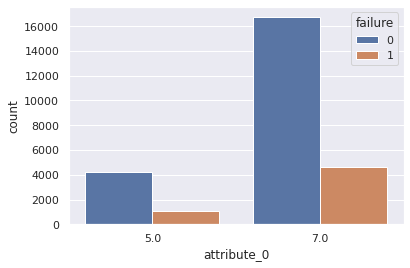

attribute_0 7.0    21320
5.0     5250
Name: attribute_0, dtype: int64


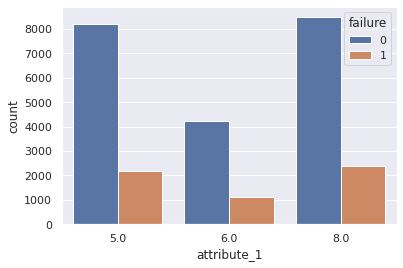

attribute_1 8.0    10865
5.0    10362
6.0     5343
Name: attribute_1, dtype: int64


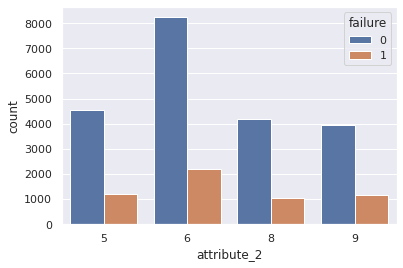

attribute_2 6    10455
5     5765
8     5250
9     5100
Name: attribute_2, dtype: int64


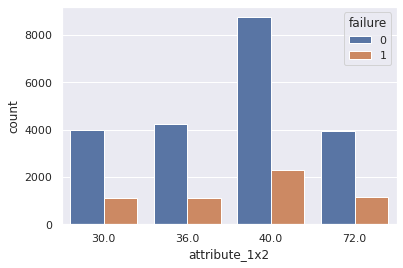

attribute_1x2 40.0    11015
36.0     5343
30.0     5112
72.0     5100
Name: attribute_1x2, dtype: int64


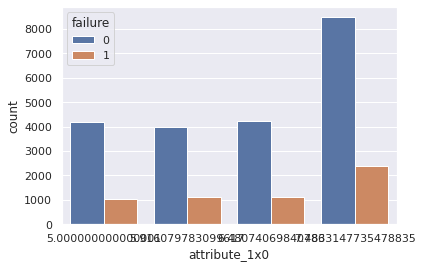

attribute_1x0 7.483315    10865
6.480741     5343
5.000000     5250
5.916080     5112
Name: attribute_1x0, dtype: int64


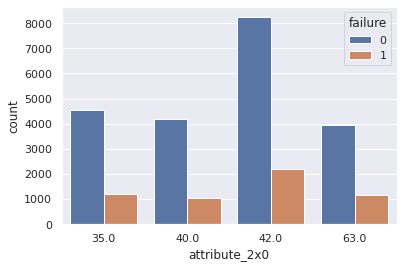

attribute_2x0 42.0    10455
35.0     5765
40.0     5250
63.0     5100
Name: attribute_2x0, dtype: int64


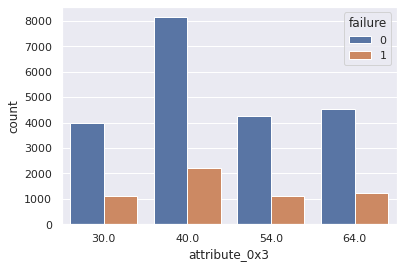

attribute_0x3 40.0    10350
64.0     5765
54.0     5343
30.0     5112
Name: attribute_0x3, dtype: int64


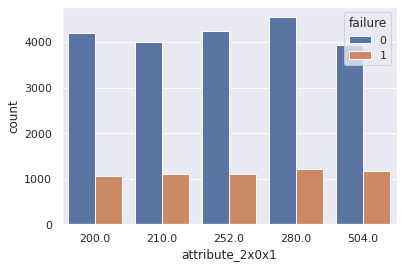

attribute_2x0x1 280.0    5765
252.0    5343
200.0    5250
210.0    5112
504.0    5100
Name: attribute_2x0x1, dtype: int64


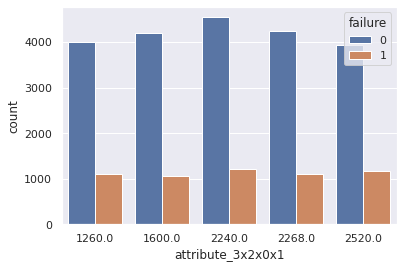

attribute_3x2x0x1 2240.0    5765
2268.0    5343
1600.0    5250
1260.0    5112
2520.0    5100
Name: attribute_3x2x0x1, dtype: int64


In [53]:
failures = main_data.copy()
failures['attribute_0'] = (failures['attribute_0'].apply(lambda x:x.split('_')[1])).astype(float)
failures['attribute_1'] = (failures['attribute_1'].apply(lambda x:x.split('_')[1])).astype(float)

failure = failures 
fails = failures[failures['failure'] == 1]

# for kal in failure.columns:
kal = 'attribute_0'
sns.countplot(data=failure, x=str(kal),  hue='failure')
plt.show()
print(f'{kal}', failure[kal].value_counts())



kal = 'attribute_1'
sns.countplot(data=failure, x=str(kal),  hue='failure')
plt.show()
print(f'{kal}', failure[kal].value_counts())



kal = 'attribute_2'
sns.countplot(data=failure, x=str(kal),  hue='failure')
plt.show()
print(f'{kal}', failure[kal].value_counts())



failure['attribute_1x2']  = np.multiply(failure['attribute_1']   ,failure['attribute_2'] )
kal = 'attribute_1x2'
sns.countplot(data=failure, x=str(kal),  hue='failure')
# plt.xticks(rotation=90)
plt.show()
print(f'{kal}', failure[kal].value_counts())




failure['attribute_1x0']  = np.multiply(np.sqrt(failure['attribute_1'])   ,np.sqrt(failure['attribute_0'] ))
kal = 'attribute_1x0'
sns.countplot(data=failure, x=str(kal),  hue='failure')
# plt.xticks(rotation=90)
plt.show()
print(f'{kal}', failure[kal].value_counts())




failure['attribute_2x0']  = np.multiply(failure['attribute_2']   ,failure['attribute_0'] )
kal = 'attribute_2x0'
sns.countplot(data=failure, x=str(kal),  hue='failure')
# plt.xticks(rotation=90)
plt.show()
print(f'{kal}', failure[kal].value_counts())




failure['attribute_0x3']  = np.multiply(failure['attribute_1']   ,failure['attribute_3'] )
kal = 'attribute_0x3'
sns.countplot(data=failure, x=str(kal),  hue='failure')
# plt.xticks(rotation=90)
plt.show()
print(f'{kal}', failure[kal].value_counts())

failure['attribute_2x0x1']  = (failure['attribute_2']*failure['attribute_0']*failure['attribute_1'] )
kal = 'attribute_2x0x1'
sns.countplot(data=failure, x=str(kal),  hue='failure')
# plt.xticks(rotation=90)
plt.show()
print(f'{kal}', failure[kal].value_counts())

failure['attribute_3x2x0x1']  = (failure['attribute_3']*failure['attribute_2']*failure['attribute_0']*failure['attribute_1'] )
kal = 'attribute_3x2x0x1'
sns.countplot(data=failure, x=str(kal),  hue='failure')
# plt.xticks(rotation=90)
plt.show()
print(f'{kal}', failure[kal].value_counts())

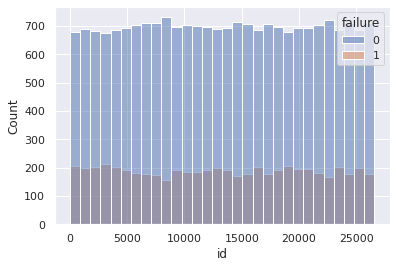

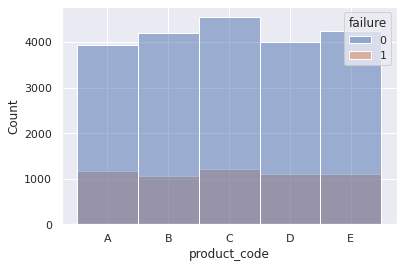

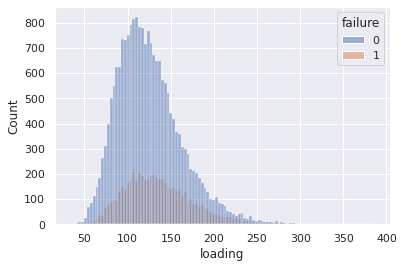

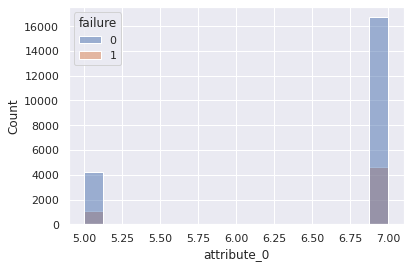

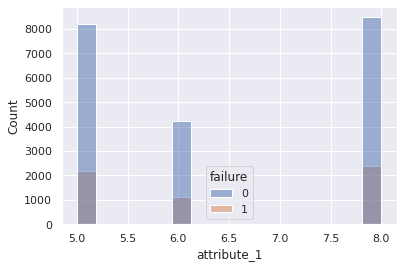

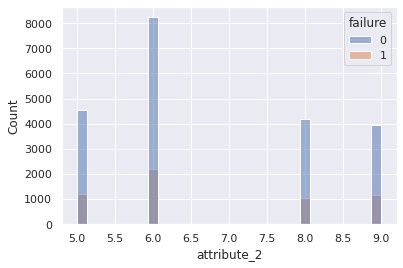

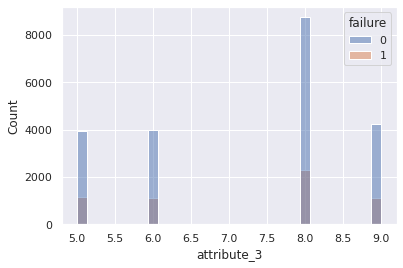

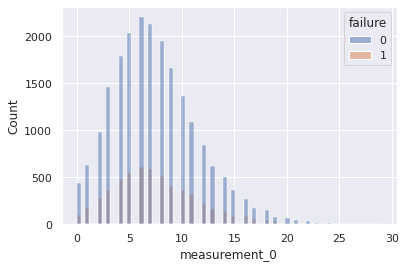

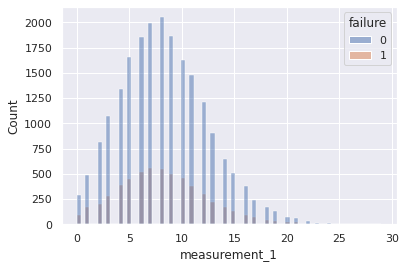

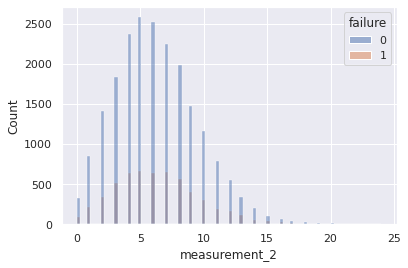

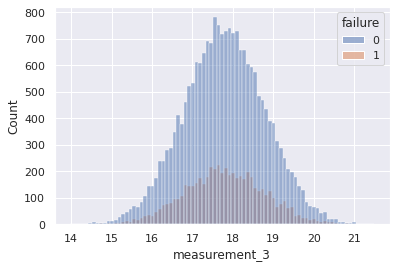

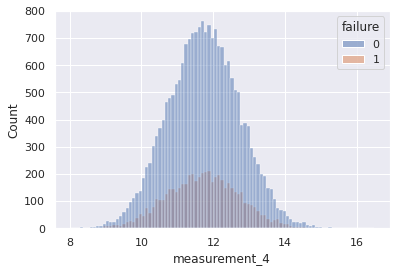

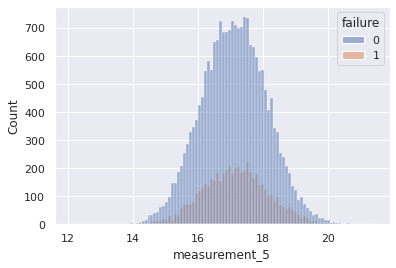

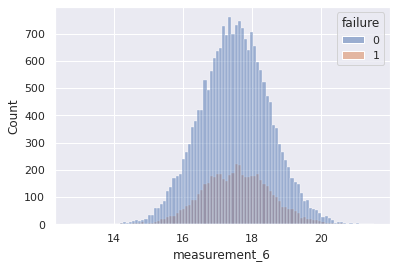

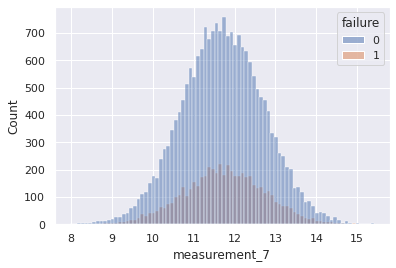

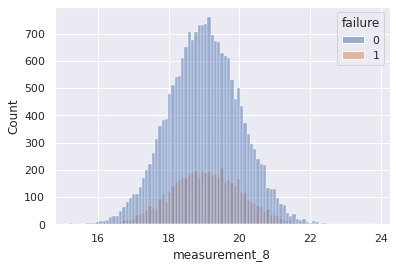

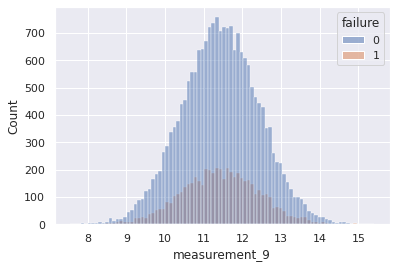

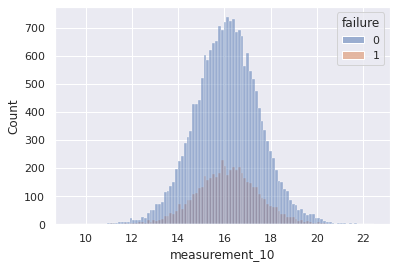

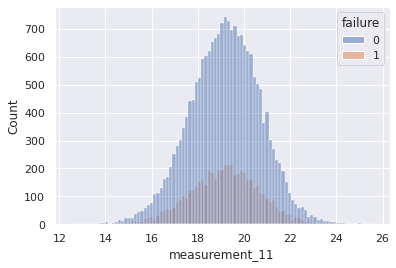

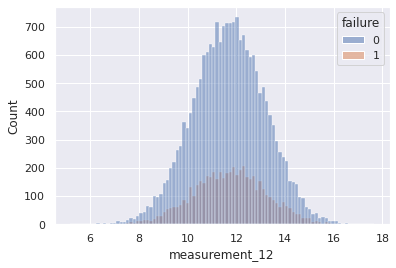

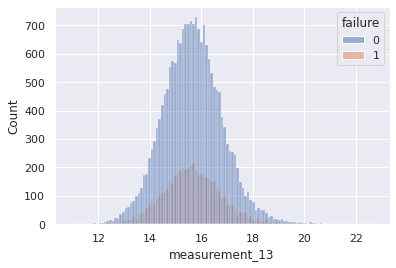

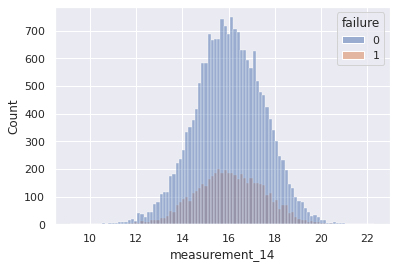

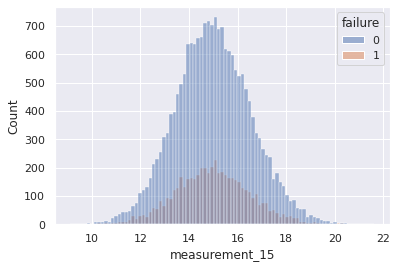

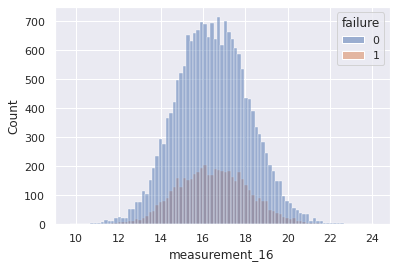

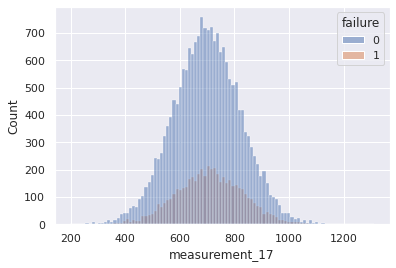

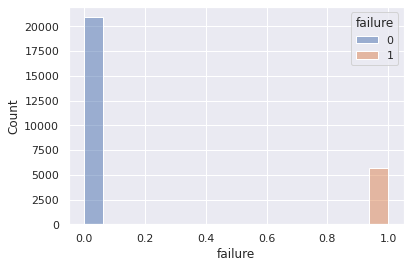

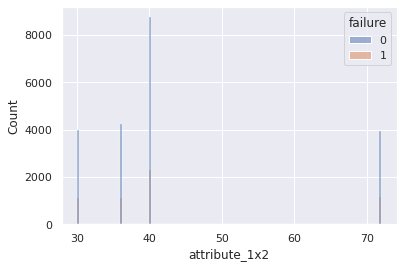

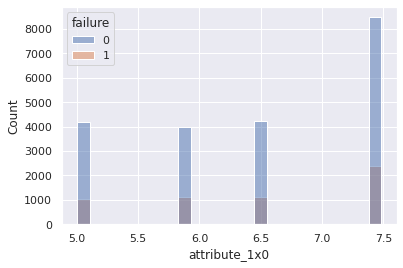

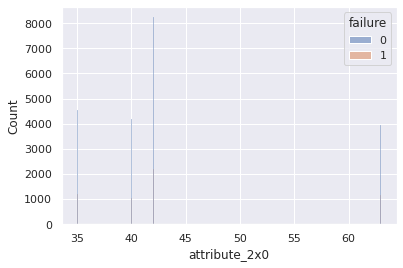

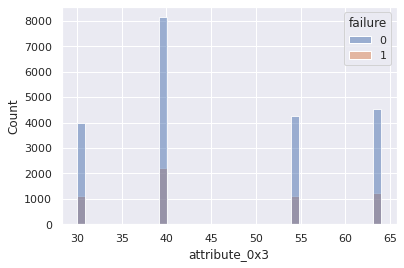

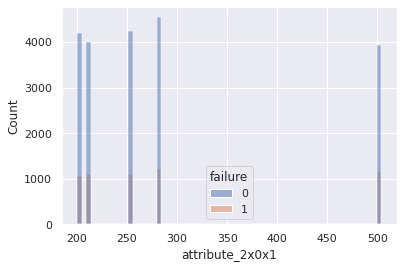

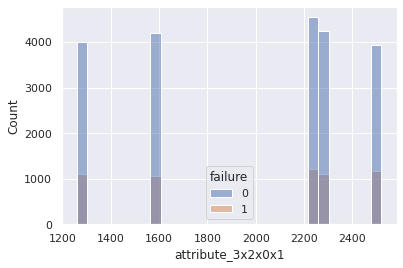

In [54]:
for kolo in failures.columns:
    try:
        sns.histplot(data=failures, x=str(kolo), hue='failure')
        plt.show()
    except:
        pass

In [55]:

failure.dtypes
# j = 0
# jfig = plt.figure(figsize=(25,40))

# for col in failure.columns:
#     j+=1
#     subs = jfig.add_subplot(5,5,j)
#     subs.set_xlabel(col)
#     sns.boxplot(data=failure, x='failure',y=col)

id                     int64
product_code          object
loading              float64
attribute_0          float64
attribute_1          float64
attribute_2            int64
attribute_3            int64
measurement_0          int64
measurement_1          int64
measurement_2          int64
measurement_3        float64
measurement_4        float64
measurement_5        float64
measurement_6        float64
measurement_7        float64
measurement_8        float64
measurement_9        float64
measurement_10       float64
measurement_11       float64
measurement_12       float64
measurement_13       float64
measurement_14       float64
measurement_15       float64
measurement_16       float64
measurement_17       float64
failure                int64
attribute_1x2        float64
attribute_1x0        float64
attribute_2x0        float64
attribute_0x3        float64
attribute_2x0x1      float64
attribute_3x2x0x1    float64
dtype: object

In [56]:
failures
failure

,id,product_code,loading,attribute_0,attribute_1,attribute_2,attribute_3,measurement_0,measurement_1,measurement_2,...,measurement_15,measurement_16,measurement_17,failure,attribute_1x2,attribute_1x0,attribute_2x0,attribute_0x3,attribute_2x0x1,attribute_3x2x0x1
0,0,A,80.10,7.0,8.0,9,5,7,8,4,...,13.034,14.684,764.100,0,72.0,7.483315,63.0,40.0,504.0,2520.0
1,1,A,84.89,7.0,8.0,9,5,14,3,3,...,14.395,15.631,682.057,0,72.0,7.483315,63.0,40.0,504.0,2520.0
2,2,A,82.43,7.0,8.0,9,5,12,1,5,...,14.094,17.946,663.376,0,72.0,7.483315,63.0,40.0,504.0,2520.0
3,3,A,101.07,7.0,8.0,9,5,13,2,6,...,16.154,17.172,826.282,0,72.0,7.483315,63.0,40.0,504.0,2520.0
4,4,A,188.06,7.0,8.0,9,5,9,2,8,...,13.153,16.412,579.885,0,72.0,7.483315,63.0,40.0,504.0,2520.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26565,26565,E,158.95,7.0,6.0,6,9,6,16,4,...,16.144,NaN,729.131,0,36.0,6.480741,42.0,54.0,252.0,2268.0
26566,26566,E,146.02,7.0,6.0,6,9,10,12,8,...,13.146,16.471,853.924,0,36.0,6.480741,42.0,54.0,252.0,2268.0
26567,26567,E,115.62,7.0,6.0,6,9,1,10,1,...,15.590,14.065,750.364,0,36.0,6.480741,42.0,54.0,252.0,2268.0
26568,26568,E,106.38,7.0,6.0,6,9,2,9,4,...,13.624,12.865,730.156,0,36.0,6.480741,42.0,54.0,252.0,2268.0


# Pipelines

In [57]:
def random_forest_class():
    ## random forest classifier
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.ensemble import RandomForestClassifier


    rfc_mdl = RandomForestClassifier(random_state=RS)
    rfc_params =  {
                    'n_estimators':[10,50,100,150,200],
                    'max_depth':list(range(2,25)),
                    'criterion':["gini", "entropy",'log_loss'],
                    'max_features':['auto','sqrt','log2']
                    }


    rfc_rsc = RandomizedSearchCV(rfc_mdl, rfc_params, scoring='roc_auc',
                                 random_state=RS, n_jobs=-1)

    rfc_rsc.fit(x_train, y_train)
    rfc_rsc.best_estimator_

In [58]:

# ### random forest pipeline

# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder

# # Preprocessing for numerical data
# numerical_transformer = SimpleImputer(strategy='constant')

# # Preprocessing for categorical data
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# # Bundle preprocessing for numerical and categorical data
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])



# from sklearn.ensemble import RandomForestClassifier

# model = RandomForestClassifier(n_estimators=100, random_state=0)


# from sklearn.metrics import mean_absolute_error

# # Bundle preprocessing and modeling code in a pipeline
# my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
#                               ('model', model)
#                              ])

# # Preprocessing of training data, fit model 
# my_pipeline.fit(X_train, y_train)

# # Preprocessing of validation data, get predictions
# preds = my_pipeline.predict(X_valid)

# # Evaluate the model
# score = mean_absolute_error(y_valid, preds)
# print('MAE:', score)


# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer

# my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
#                               ('model', RandomForestRegressor(n_estimators=50,
#                                                               random_state=0))
#                              ])


# from sklearn.model_selection import cross_val_score

# # Multiply by -1 since sklearn calculates *negative* MAE
# scores = -1 * cross_val_score(my_pipeline, X, y,
#                               cv=5,
#                               scoring='neg_mean_absolute_error')

# print("MAE scores:\n", scores)

# print("Average MAE score (across experiments):")
# print(scores.mean())